# ============================================================
#  Predictive Maintenance Analysis
# ============================================================

In [100]:
# ============================================================
#  1. Setup & Imports
# ============================================================

# Data handling
import pandas as pd
import numpy as np
import os
import kagglehub
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math

# Machine learning (for later sections)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [101]:
# ============================================================
#  2. Global Plot & Style Configuration
# ============================================================

# Unified font and size
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Seaborn theme (modern, clean, scientific look)
sns.set_theme(
    style='whitegrid',
    font='DejaVu Sans',
    rc={'font.size': 14}
)

# Visualization style and unified palette
plt.style.use("seaborn-v0_8-whitegrid")
PALETTE = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
sns.set_palette(PALETTE)

print("✅ Environment ready — all styles, fonts, and colors set.")

✅ Environment ready — all styles, fonts, and colors set.


In [102]:
# ============================================================
#  3. Data Loading
# ============================================================

data_path = os.path.join("..", "data", "raw", "predictive_maintenance.csv")

if not os.path.exists(data_path):
    raise FileNotFoundError(f"❌ File not found: {data_path}")
else:
    print(f"✅ Dataset found at: {data_path}")


df = pd.read_csv(data_path)


print("📊 DataFrame loaded successfully!\n")
display(df.head())
print("\n🔍 Data info:")
print(df.info())

# Overview of the dataset
print("\n🔹 Dataset shape:", df.shape)


✅ Dataset found at: ..\data\raw\predictive_maintenance.csv
📊 DataFrame loaded successfully!



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.100,308.600,1551,42.800,0,0,No Failure
1,2,L47181,L,298.200,308.700,1408,46.300,3,0,No Failure
2,3,L47182,L,298.100,308.500,1498,49.400,5,0,No Failure
3,4,L47183,L,298.200,308.600,1433,39.500,7,0,No Failure
4,5,L47184,L,298.200,308.700,1408,40.000,9,0,No Failure



🔍 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None

🔹 Dataset shape: (10000, 10)


In [103]:
# ============================================================
#  4.1. Basic Cleaning: Failure abbreviations
# ============================================================

#  Replace empty/NaN values with "No Failure"
df["Failure Type"] = df["Failure Type"].fillna("No Failure")

#  Create dummy columns (one 0/1 column for each failure type)
failure_dummies = pd.get_dummies(df["Failure Type"])

#  Append dummy columns to the original DataFrame
df = pd.concat([df, failure_dummies], axis=1)

#  Standardization of column names
df.rename(columns={
    "Tool Wear Failure": "TWF",
    "Heat Dissipation Failure": "HDF",
    "Power Failure": "PWF",
    "Overstrain Failure": "OSF",
    "Random Failures": "RNF"
}, inplace=True)

# Current column order
cols = list(df.columns)

if "No Failure" in cols and "HDF" in cols:
    cols.remove("HDF")

    insert_pos = cols.index("No Failure") + 1
    cols.insert(insert_pos, "HDF")

    df = df[cols]

#  Verification
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,No Failure,HDF,OSF,PWF,RNF,TWF
0,1,M14860,M,298.100,308.600,1551,42.800,0,0,No Failure,True,False,False,False,False,False
1,2,L47181,L,298.200,308.700,1408,46.300,3,0,No Failure,True,False,False,False,False,False
2,3,L47182,L,298.100,308.500,1498,49.400,5,0,No Failure,True,False,False,False,False,False
3,4,L47183,L,298.200,308.600,1433,39.500,7,0,No Failure,True,False,False,False,False,False
4,5,L47184,L,298.200,308.700,1408,40.000,9,0,No Failure,True,False,False,False,False,False


In [104]:
# ============================================================
#  4.2. Basic Cleaning: Filter for failures
# ============================================================

df[df["Target"]==1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,No Failure,HDF,OSF,PWF,RNF,TWF
50,51,L47230,L,298.900,309.100,2861,4.600,143,1,Power Failure,False,False,False,True,False,False
69,70,L47249,L,298.900,309.000,1410,65.700,191,1,Power Failure,False,False,False,True,False,False
77,78,L47257,L,298.800,308.900,1455,41.300,208,1,Tool Wear Failure,False,False,False,False,False,True
160,161,L47340,L,298.400,308.200,1282,60.700,216,1,Overstrain Failure,False,False,True,False,False,False
161,162,L47341,L,298.300,308.100,1412,52.300,218,1,Overstrain Failure,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.600,309.800,2271,16.200,218,1,Tool Wear Failure,False,False,False,False,False,True
9764,9765,L56944,L,298.500,309.500,1294,66.700,12,1,Power Failure,False,False,False,True,False,False
9822,9823,L57002,L,298.500,309.400,1360,60.900,187,1,Overstrain Failure,False,False,True,False,False,False
9830,9831,L57010,L,298.300,309.300,1337,56.100,206,1,Overstrain Failure,False,False,True,False,False,False


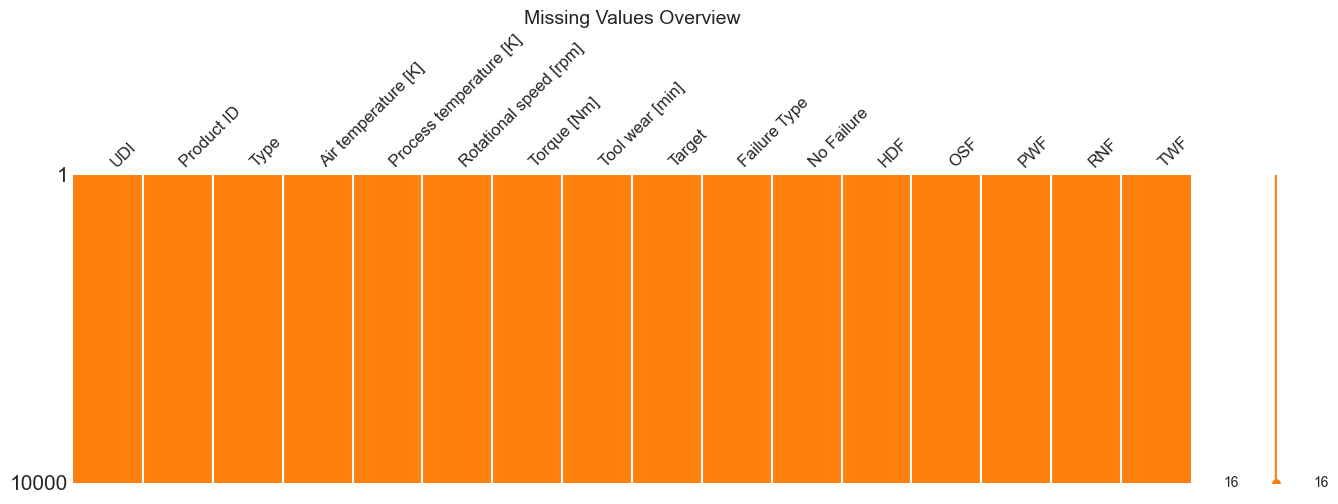

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.500000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.895680,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.750000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.500000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.250000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000



 Missing values per column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
No Failure                 0
HDF                        0
OSF                        0
PWF                        0
RNF                        0
TWF                        0
dtype: int64


In [105]:
# ============================================================
# 4.3. Basic Cleaning: Check for Missing Values
# ============================================================

# Check for missing values visually
msno.matrix(df, figsize=(16, 4), fontsize=12, color=(1.0, 0.5, 0.06))
plt.title("Missing Values Overview", fontsize=14)
plt.show()


# Check numeric summary
display(df.describe().style.background_gradient(cmap="Blues"))

# Check for null values in each column
print("\n Missing values per column:")
print(df.isnull().sum())

In [106]:
# ============================================================
#  4.4. Basic Cleaning: Check for Unique Values
# ============================================================

df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
No Failure                     2
HDF                            2
OSF                            2
PWF                            2
RNF                            2
TWF                            2
dtype: int64

In [107]:
# ============================================================
#  4.5. Basic Cleaning: Drop Unnecessary Columns
# ============================================================

# Drop columns that are purely identifiers (not useful for modeling)
df = df.drop(columns=["UDI", "Product ID"])
df.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,No Failure,HDF,OSF,PWF,RNF,TWF
0,M,298.100,308.600,1551,42.800,0,0,No Failure,True,False,False,False,False,False
1,L,298.200,308.700,1408,46.300,3,0,No Failure,True,False,False,False,False,False
2,L,298.100,308.500,1498,49.400,5,0,No Failure,True,False,False,False,False,False
3,L,298.200,308.600,1433,39.500,7,0,No Failure,True,False,False,False,False,False
4,L,298.200,308.700,1408,40.000,9,0,No Failure,True,False,False,False,False,False


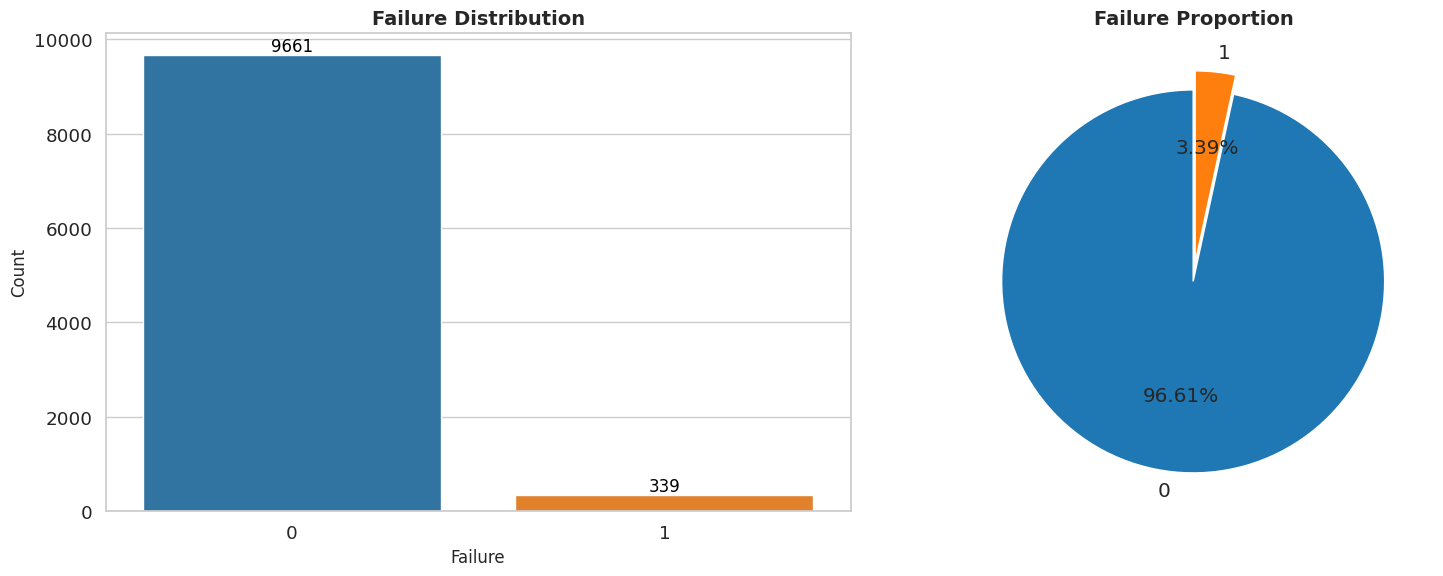

In [108]:
# ============================================================
#  5.1. Exploratory Data Analysis: Check for Failure Amount
# ============================================================

colors = ["#1f77b4", "#ff7f0e"]
sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = sns.countplot(x="Target", data=df, palette=colors, ax=axes[0])

for container in ax1.containers:
    ax1.bar_label(container, fontsize=12, color="black")

ax1.set_title("Failure Distribution", fontsize=14, fontweight="bold")
ax1.set_xlabel("Failure", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)

# Pie Chart
target_counts = df["Target"].value_counts()
axes[1].pie(
    target_counts,
    labels=target_counts.index,
    autopct="%1.2f%%",
    startangle=90,
    colors=colors,
    explode=[0.05] * len(target_counts),
    shadow=False, 
    textprops={"fontsize": 12, "font": "DejaVu Sans"},
)
axes[1].set_title("Failure Proportion", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


In [109]:
# ============================================================
#  5.2. Exploratory Data Analysis: Check for Anomalies
# ============================================================

# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [110]:
# Delete Anomalies where RNF=1 but Target=0
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [111]:
# Anomalies where failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [112]:
amount = df.shape[0]
# Global percentage of removed observations
print('Global percentage of removed observations:',
     round(100*(first_drop+second_drop)/amount, 2))
df.reset_index(drop=True, inplace=True) 


Global percentage of removed observations: 0.27


Failures percentage in data: 3.31


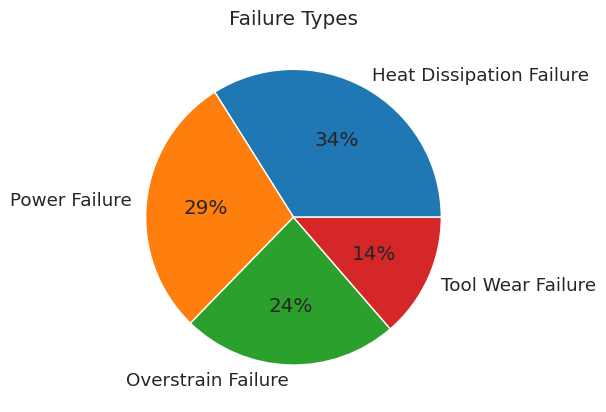

In [113]:
# Data with failure types
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/amount,2))

# Pie plot
plt.title('Failure Types')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

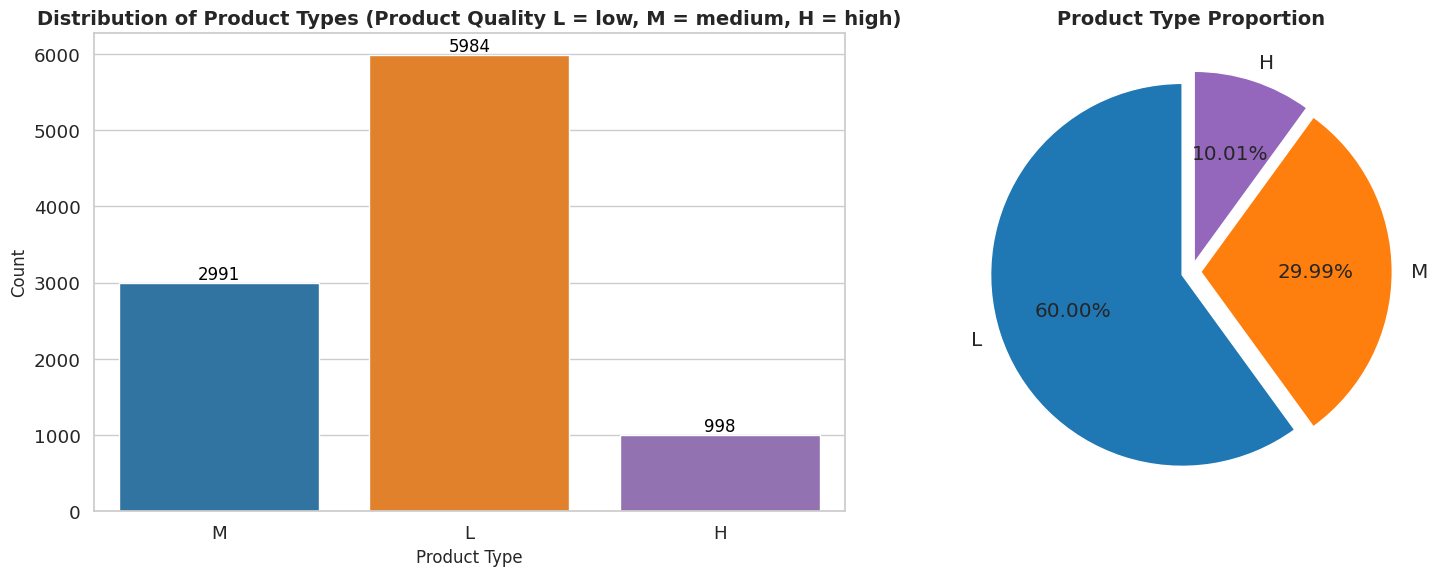

In [114]:
# ============================================================
#  5.3. Exploratory Data Analysis: Check for Product Types
# ============================================================

colors = ["#1f77b4", "#ff7f0e", "#9467bd"]
sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Countplot
ax1 = sns.countplot(x="Type", data=df, palette=colors, ax=axes[0])


for container in ax1.containers:
    ax1.bar_label(container, fontsize=12, color="black")

# Titles and labels
ax1.set_title("Distribution of Product Types (Product Quality L = low, M = medium, H = high)", fontsize=14, fontweight="bold")
ax1.set_xlabel("Product Type", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)

# Pie Chart
type_counts = df["Type"].value_counts()

axes[1].pie(
    type_counts,
    labels=type_counts.index,
    autopct="%1.2f%%",
    startangle=90,
    colors=colors,
    explode=[0.05, 0.05, 0.05],
    shadow=False,  # disables 3D effect
    textprops={"fontsize": 12, "font": "DejaVu Sans"}
)
axes[1].set_title("Product Type Proportion", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()


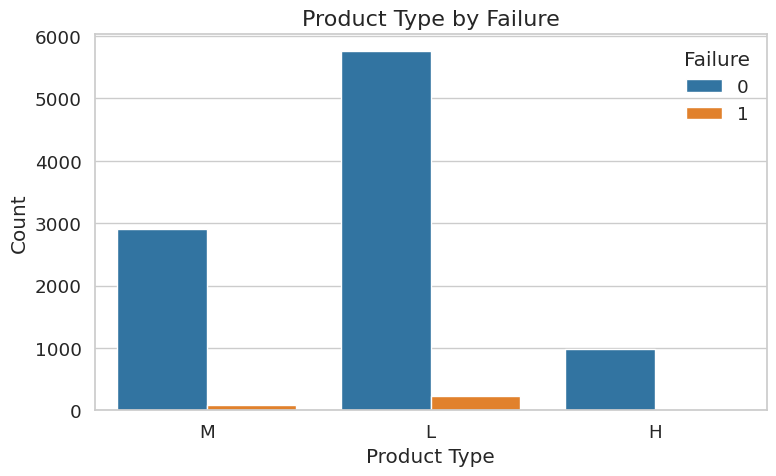

In [115]:
# Product Type by Failure
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', hue='Target', data=df, palette=PALETTE)
plt.title("Product Type by Failure", fontsize=16)
plt.xlabel("Product Type")
plt.ylabel("Count")
plt.legend(title="Failure", loc='upper right')
plt.tight_layout()
plt.show()

In [116]:
# Encode categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
print("\n Categorical columns:", list(cat_cols))

# LabelEncoder for categorical variables
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

print("\n✅ Encoding completed. Updated dataframe info:")
print(df.info())




 Categorical columns: ['Type', 'Failure Type']

✅ Encoding completed. Updated dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9973 non-null   int64  
 1   Air temperature [K]      9973 non-null   float64
 2   Process temperature [K]  9973 non-null   float64
 3   Rotational speed [rpm]   9973 non-null   int64  
 4   Torque [Nm]              9973 non-null   float64
 5   Tool wear [min]          9973 non-null   int64  
 6   Target                   9973 non-null   int64  
 7   Failure Type             9973 non-null   int64  
 8   No Failure               9973 non-null   bool   
 9   HDF                      9973 non-null   bool   
 10  OSF                      9973 non-null   bool   
 11  PWF                      9973 non-null   bool   
 12  RNF                      9973 non-nul

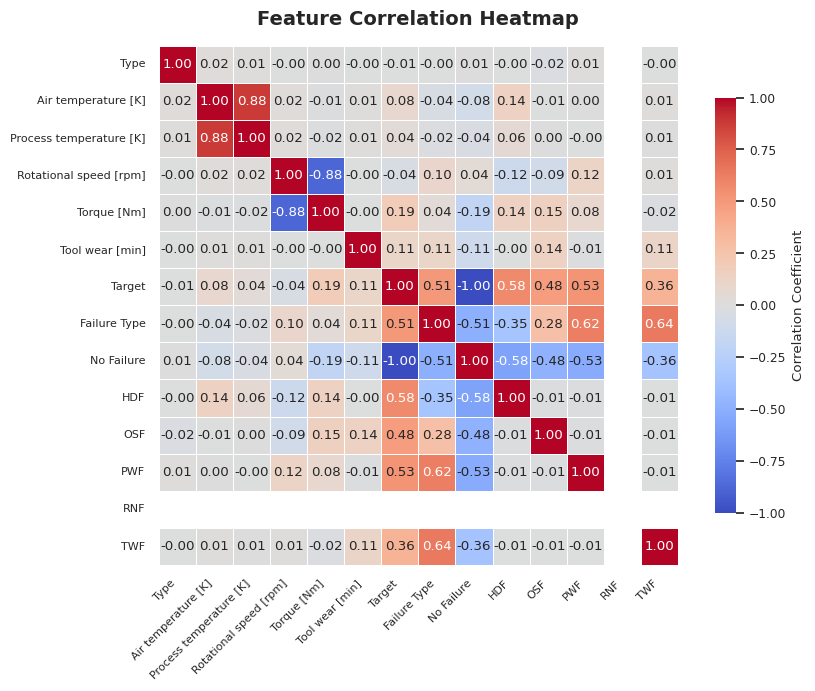

In [117]:
# ============================================================
#  5.4. Exploratory Data Analysis: Correlation Heatmap
# ============================================================

corr = df.corr(numeric_only=True)

sns.set(style="white", font="DejaVu Sans", font_scale=0.8)  # kleinere Schrift

plt.figure(figsize=(9, 7))  
sns.heatmap(
    corr,
    cmap="coolwarm",          
    annot=True,               
    fmt=".2f",                
    linewidths=0.4,           
    square=True,              
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


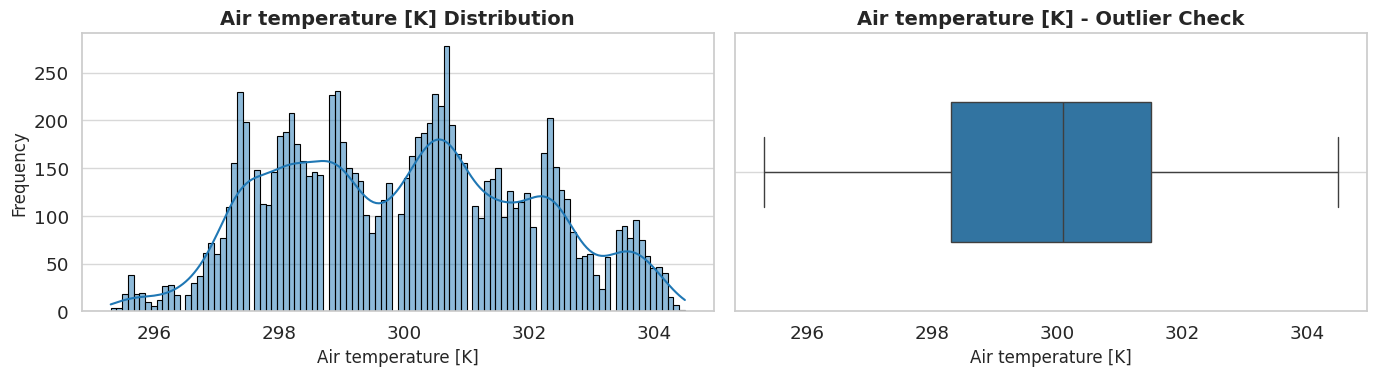

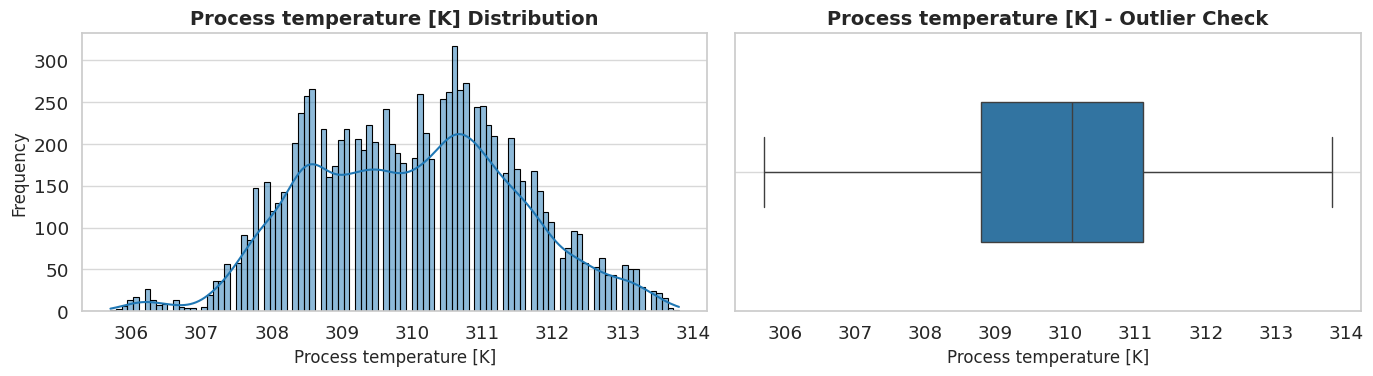

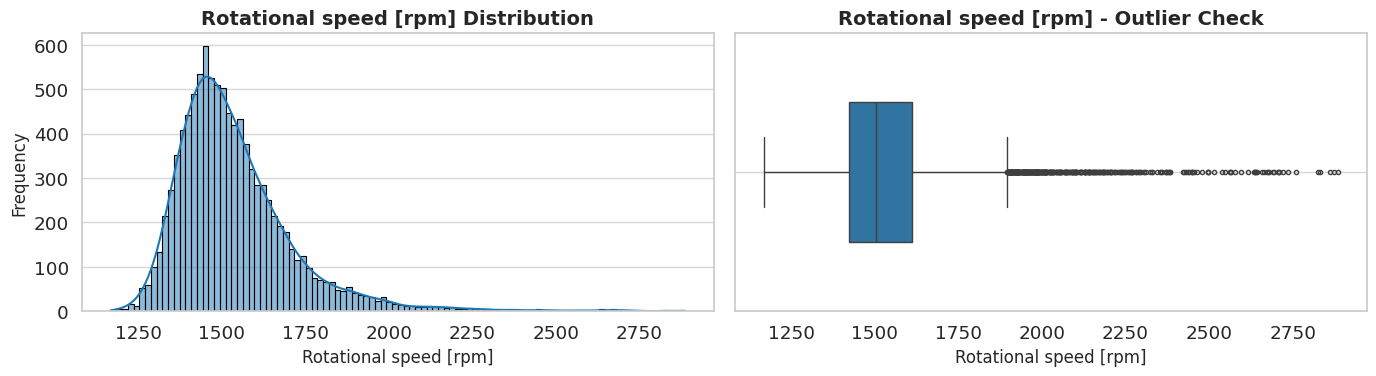

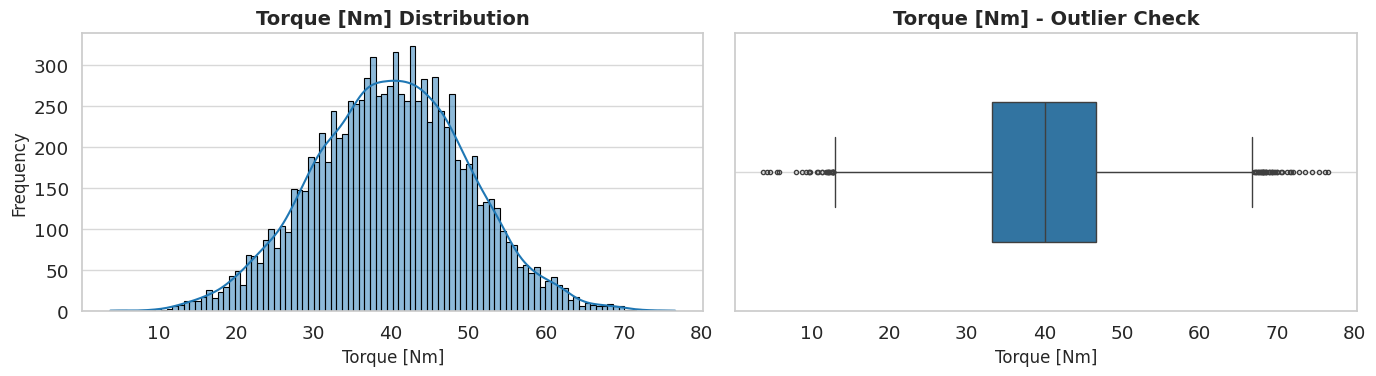

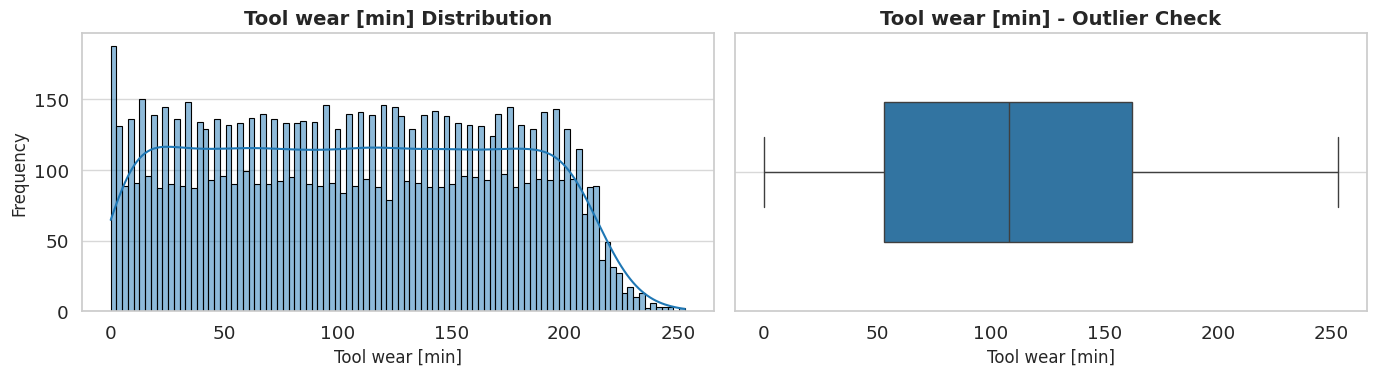

In [118]:
# ============================================================
#  5.5. Exploratory Data Analysis: Feature Distributions & Outliers
# ============================================================

sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.2)

cols = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 Reihe, 2 Spalten

    # Histogram
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        color=colors[0],
        ax=axes[0],
        bins=100,
        edgecolor="black",
        linewidth=0.8
    )
    axes[0].set_title(f"{col} Distribution", fontsize=14, fontweight="bold")
    axes[0].set_xlabel(col, fontsize=12)
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].grid(axis="x", visible=False)
    axes[0].grid(axis="y", visible=True, color="gray", alpha=0.3)

    # Boxplot
    sns.boxplot(
        data=df,
        x=col,
        color=colors[0],
        ax=axes[1],
        width=0.5,
        fliersize=3,
        linewidth=1
    )
    axes[1].set_title(f"{col} - Outlier Check", fontsize=14, fontweight="bold")
    axes[1].set_xlabel(col, fontsize=12)
    axes[1].set_ylabel("")
    axes[1].grid(axis="x", visible=False)
    axes[1].grid(axis="y", visible=True, color="gray", alpha=0.3)

    plt.tight_layout()
    plt.show()


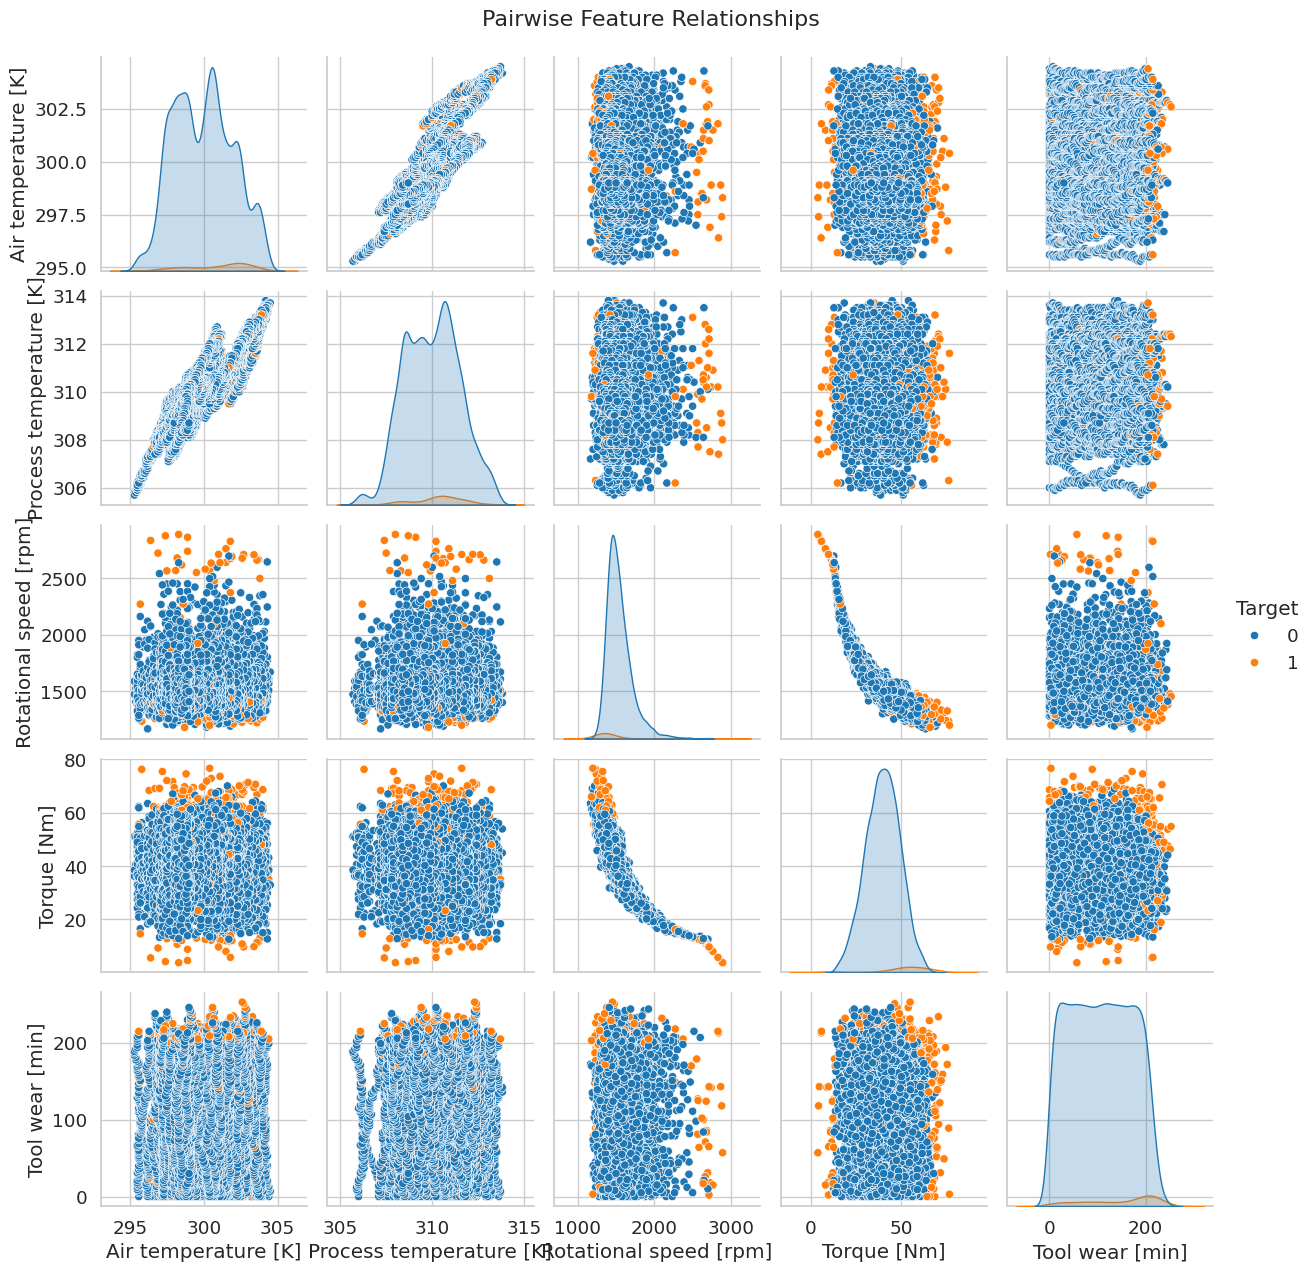

In [119]:
# ============================================================
#  5.6. Exploratory Data Analysis: Pairplot of Features
# ============================================================

sns.pairplot(
    df,
    vars=["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"],
    hue="Target",
    palette=PALETTE,
    diag_kind="kde",
    height=2.5
)
plt.suptitle("Pairwise Feature Relationships", fontsize=16, y=1.02)
plt.show()

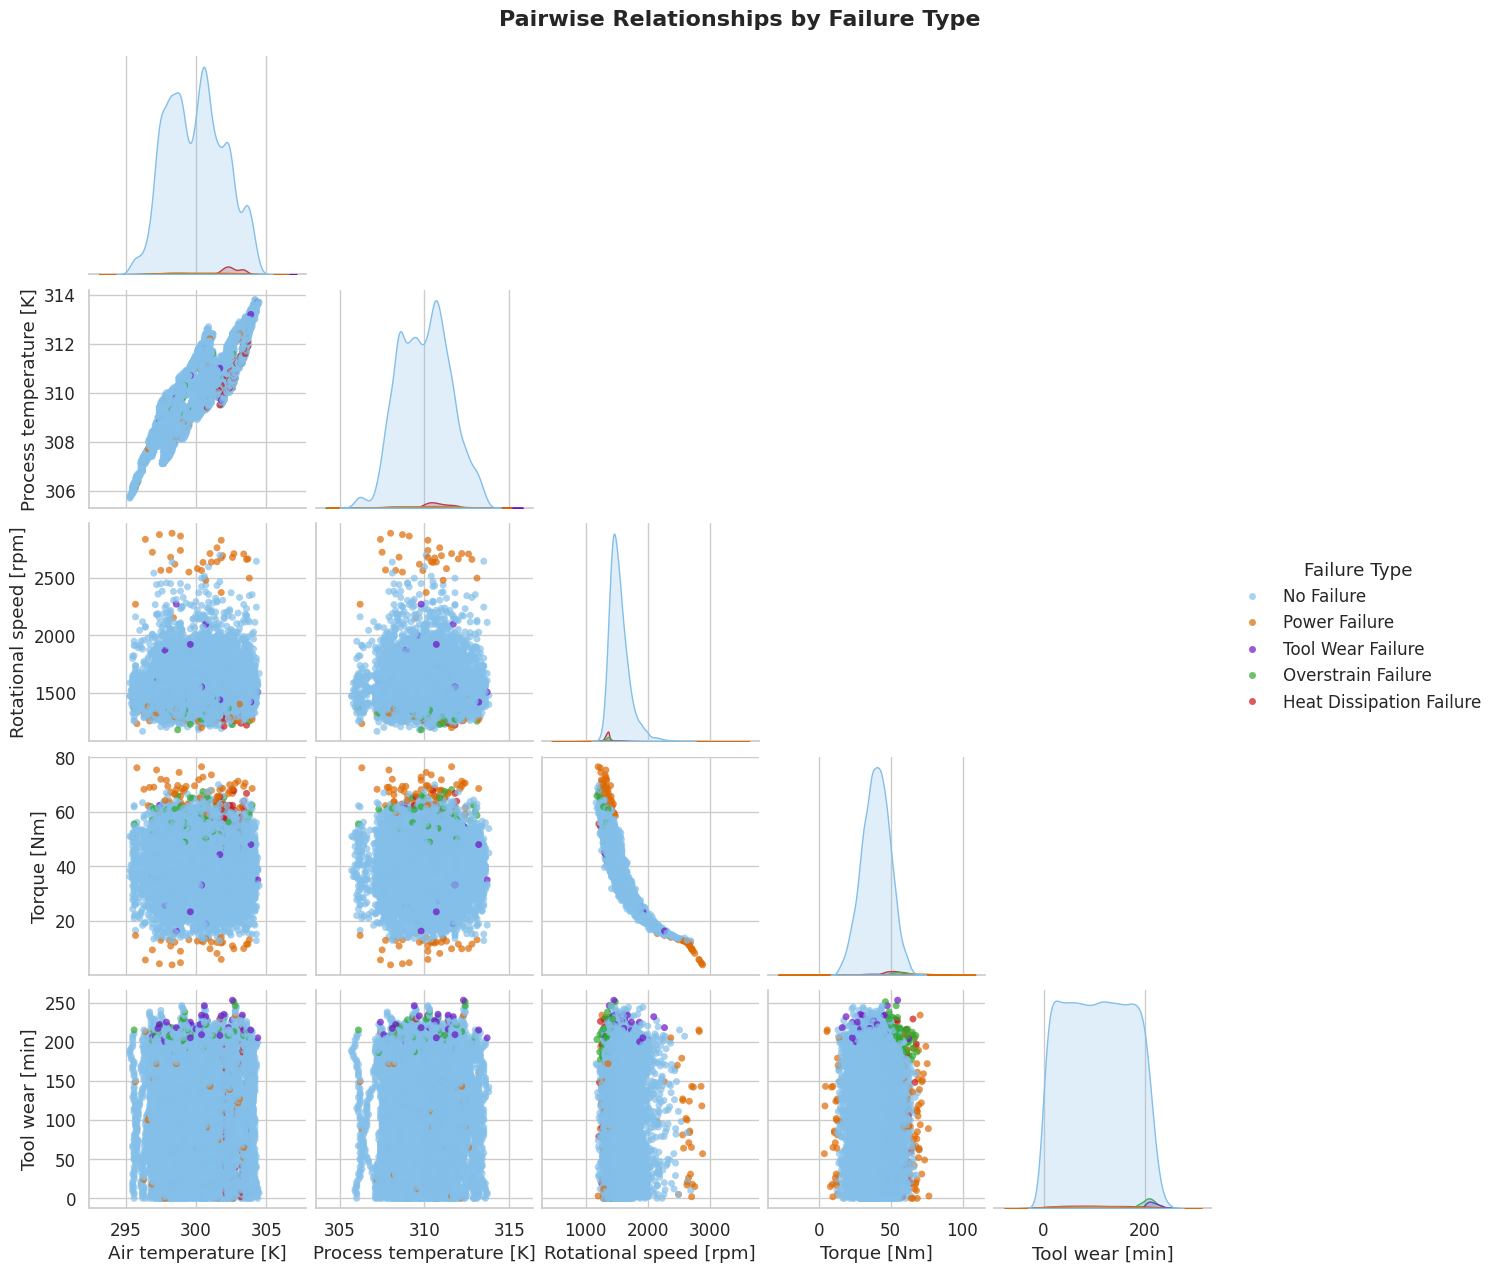

In [120]:
# ============================================================
#  5.7. Exploratory Data Analysis: Relationships by Failure Type
# ============================================================

failure_dummies = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'No Failure']
df['Failure Type'] = df[failure_dummies].idxmax(axis=1)

failure_labels = {
    "TWF": "Tool Wear Failure",
    "HDF": "Heat Dissipation Failure",
    "PWF": "Power Failure",
    "OSF": "Overstrain Failure",
    "RNF": "Random Failure",
    "No Failure": "No Failure"
}
df["Failure Type"] = df["Failure Type"].map(failure_labels)

sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.1)
PALETTE = ["#83bfe9", "#dd6a05", "#6d12c2", "#2ea82e", "#cb1515", "#8c564b"]

cols = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

pair = sns.pairplot(
    df,
    vars=cols,
    hue="Failure Type",
    palette=PALETTE,
    corner=True,
    diag_kind="kde",
    plot_kws=dict(alpha=0.7, s=25, edgecolor="none")
)

pair.fig.suptitle("Pairwise Relationships by Failure Type", fontsize=16, fontweight="bold", y=1.02)
pair._legend.set_title("Failure Type")

plt.show()


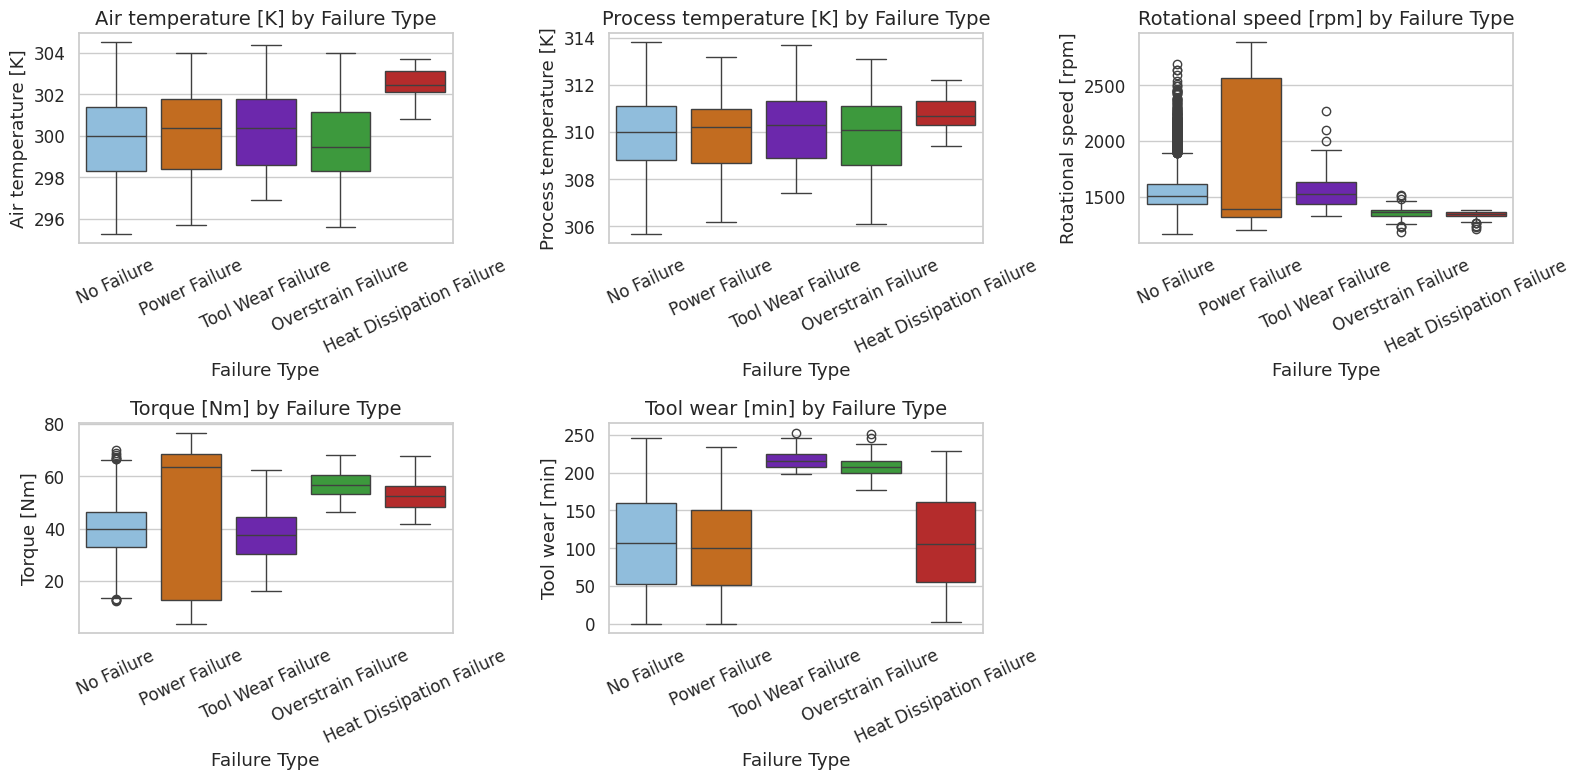

In [121]:
# ============================================================
#  5.8. Exploratory Data Analysis: Boxplots by Failure Type
# ============================================================

#import warnings
#warnings.filterwarnings("ignore")

numeric_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Failure Type', y=col, data=df, palette=PALETTE, ax=axes[i])
    axes[i].set_title(f"{col} by Failure Type", fontsize=14)
    axes[i].set_xlabel("Failure Type")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=25)

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Training Accuracy: 93.27%
Test Accuracy: 92.13%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1929
           1       0.28      0.89      0.43        66

    accuracy                           0.92      1995
   macro avg       0.64      0.91      0.69      1995
weighted avg       0.97      0.92      0.94      1995



<Figure size 600x500 with 0 Axes>

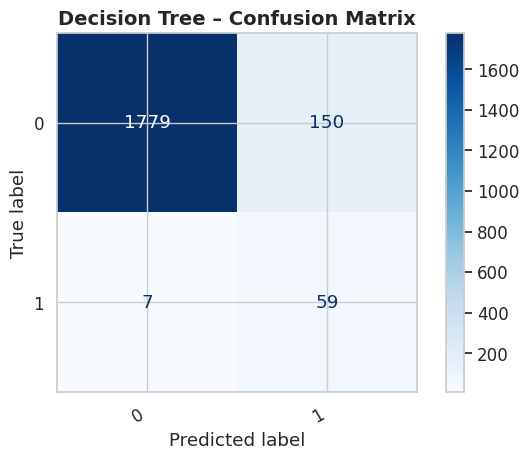

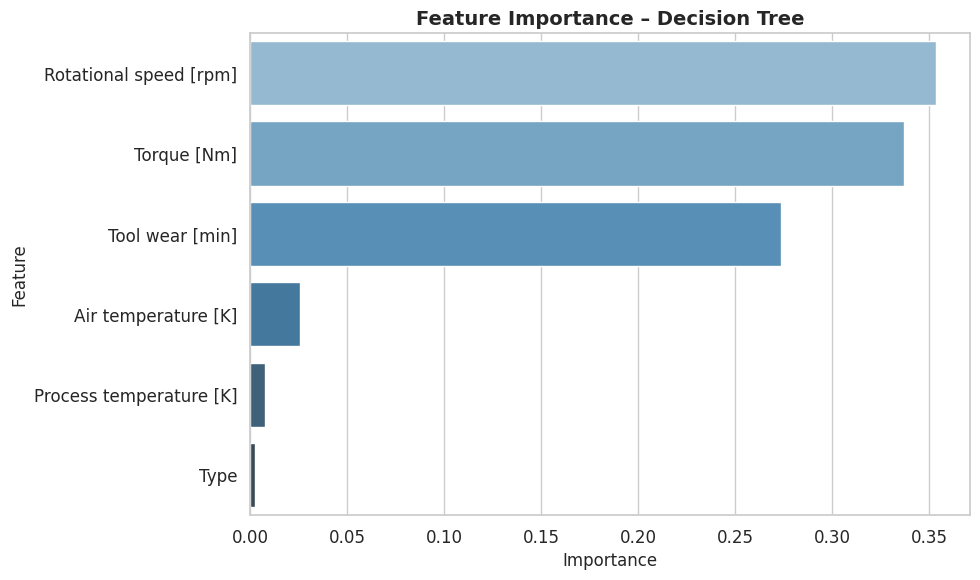

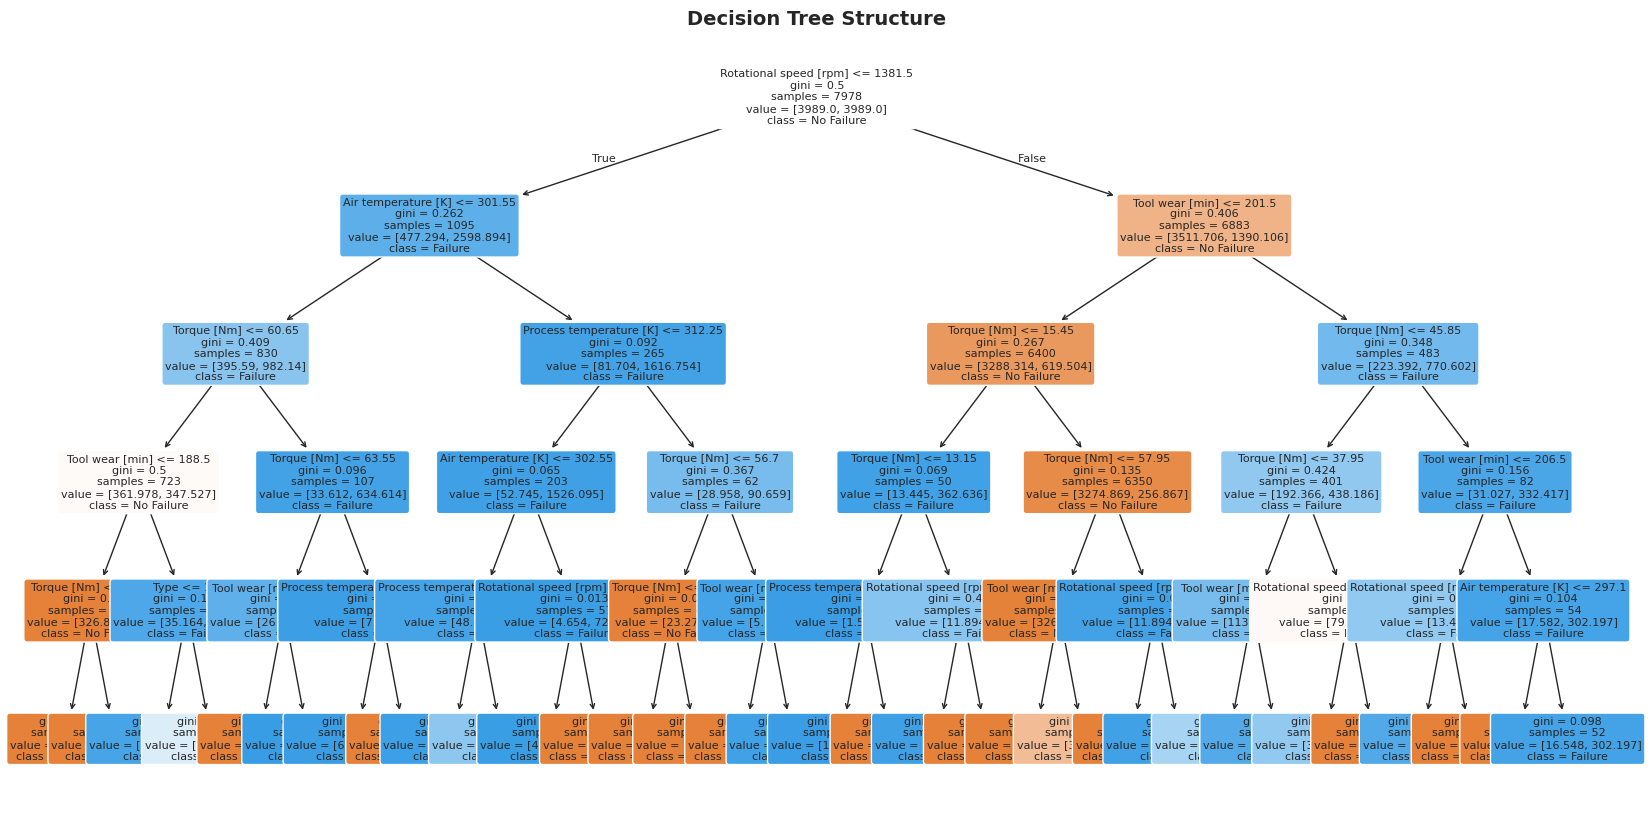

In [122]:
# ============================================================
#  6. Decision Tree Model – Predicting Machine Failure
# ============================================================

# Define features & target

features = [
    "Type",
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]
target = "Target"

# Encode categorical column "Type"
df["Type"] = df["Type"].astype("category").cat.codes

# Train/Test Split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Training
decision = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight="balanced")
decision.fit(X_train, y_train)

# Predictions & Metrics
y_pred = decision.predict(X_test)

train_acc = round(decision.score(X_train, y_train) * 100, 2)
test_acc = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f"Training Accuracy: {train_acc}%")
print(f"Test Accuracy: {test_acc}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(
    decision, X_test, y_test, cmap="Blues", colorbar=True
)
plt.title("Decision Tree – Confusion Matrix", fontsize=14, fontweight="bold")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Feature Importance
importances = decision.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="Blues_d")
plt.title("Feature Importance – Decision Tree", fontsize=14, fontweight="bold")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(
    decision,
    filled=True,
    feature_names=X_train.columns,
    class_names=["No Failure", "Failure"],
    fontsize=8,
    rounded=True
)
plt.title("Decision Tree Structure", fontsize=14, fontweight="bold")
plt.show()


Training Accuracy    : 89.07 %
Model Accuracy Score : 87.92 %
--------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.91      0.55        22
           1       1.00      0.88      0.94      1929
           2       0.23      0.75      0.35        16
           3       0.45      0.68      0.54        19
           4       0.05      0.89      0.10         9

    accuracy                           0.88      1995
   macro avg       0.42      0.82      0.49      1995
weighted avg       0.97      0.88      0.92      1995

--------------------------------------------------------


<Figure size 700x600 with 0 Axes>

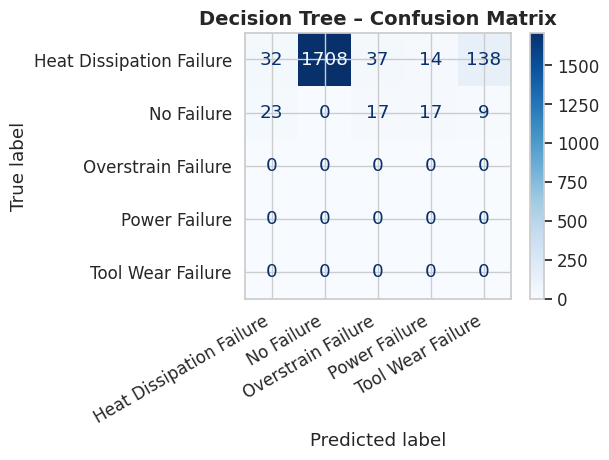

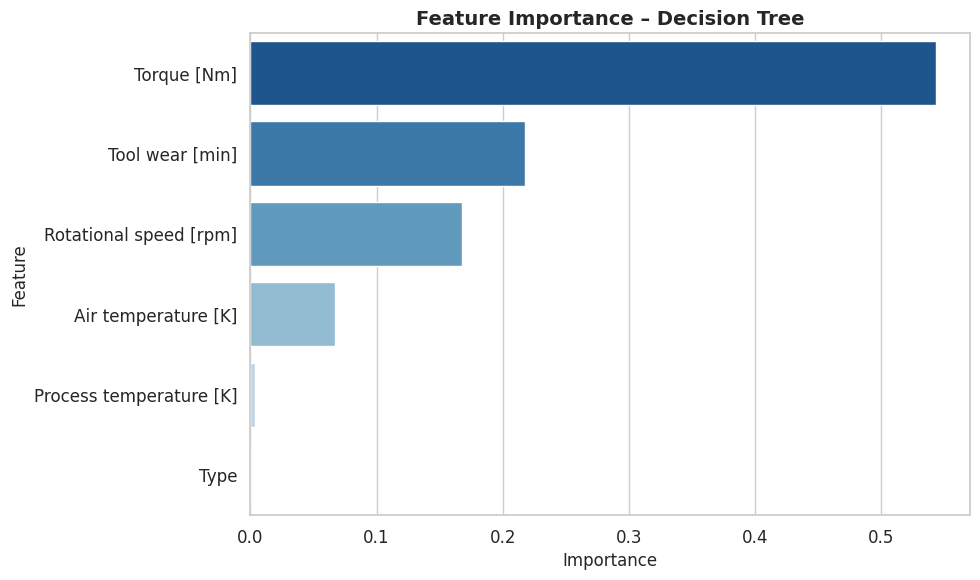

|--- Tool wear [min] <= 181.50
|   |--- Rotational speed [rpm] <= 1379.50
|   |   |--- Torque [Nm] <= 65.10
|   |   |   |--- Air temperature [K] <= 301.35
|   |   |   |   |--- Torque [Nm] <= 62.35
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Torque [Nm] >  62.35
|   |   |   |   |   |--- class: 3
|   |   |   |--- Air temperature [K] >  301.35
|   |   |   |   |--- Process temperature [K] <= 312.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Process temperature [K] >  312.25
|   |   |   |   |   |--- class: 1
|   |   |--- Torque [Nm] >  65.10
|   |   |   |--- Rotational speed [rpm] <= 1231.50
|   |   |   |   |--- Tool wear [min] <= 141.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Tool wear [min] >  141.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Rotational speed [rpm] >  1231.50
|   |   |   |   |--- Torque [Nm] <= 66.20
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- Torque [Nm] >  66.20
|   |   |   |   |   |--- class: 3
|   |--- Rotationa

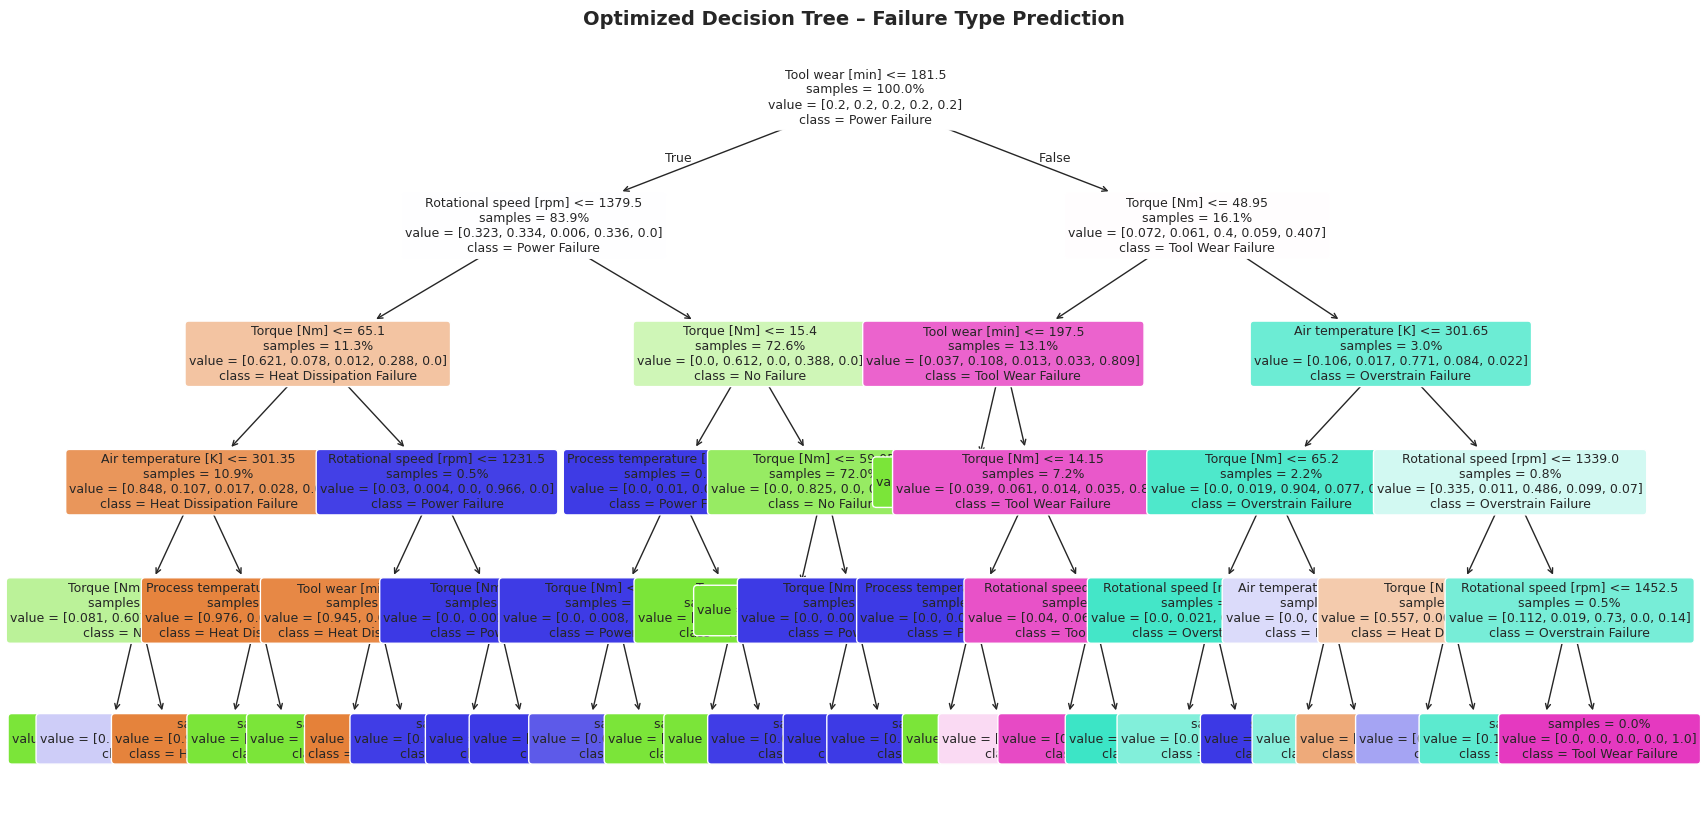

In [123]:
# ============================================================
#  7. Decision Tree Model – Multiclass: Failure Type Prediction
# ============================================================


#  Prepare data

# Zielvariable: "Failure Type"
# "Target" (Failure/No Failure) darf nicht als Feature verwendet werden (Leckage!)
# Encoding für "Type" (categorical)
df_encoded = df.copy()

label_enc = LabelEncoder()
df_encoded["Type"] = label_enc.fit_transform(df_encoded["Type"])
df_encoded["Failure Type Encoded"] = label_enc.fit_transform(df_encoded["Failure Type"])

# Features (ohne Zielspalten)
feature_cols = [
    "Type",
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

X = df_encoded[feature_cols]
y = df_encoded["Failure Type Encoded"]

# Split in Train/Test
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree
decision_multi = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight="balanced")
decision_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_multi = decision_multi.predict(X_test_multi)

# Accuracy
train_acc = round(decision_multi.score(X_train_multi, y_train_multi) * 100, 2)
test_acc = round(accuracy_score(y_test_multi, y_pred_multi) * 100, 2)

print(f"Training Accuracy    : {train_acc} %")
print(f"Model Accuracy Score : {test_acc} %")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification Report:\n", classification_report(y_test_multi, y_pred_multi))
print("\033[1m--------------------------------------------------------\033[0m")

# Confusion Matrix
# Mapping numerischer Labels -> Originalnamen
class_mapping = dict(enumerate(df["Failure Type"].astype("category").cat.categories))

plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay.from_estimator(
    decision_multi,
    X_test,
    y_test,
    display_labels=[class_mapping[i] for i in range(len(class_mapping))],
    cmap="Blues",
    colorbar=True
)
plt.title("Decision Tree – Confusion Matrix", fontsize=14, fontweight="bold")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Feature Importance
importances = decision_multi.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp_df,
    palette="Blues_r"
)
plt.title("Feature Importance – Decision Tree", fontsize=14, fontweight="bold")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Decision Tree Visualization – Optimiert & Kompakt
from sklearn.tree import export_text

#  Textuelle Version
r = export_text(decision_multi, feature_names=list(X_train.columns))
print(r[:1000])

# Grafik-Plot
plt.figure(figsize=(20, 10))
class_names_str = [str(class_mapping[i]) for i in range(len(class_mapping))]

plot_tree(
    decision_multi,
    feature_names=X_train.columns,
    class_names=class_names_str,
    filled=True,
    rounded=True,
    fontsize=9,
    proportion=True,
    impurity=False 
)

plt.title("Optimized Decision Tree – Failure Type Prediction", fontsize=14, fontweight="bold")
plt.show()

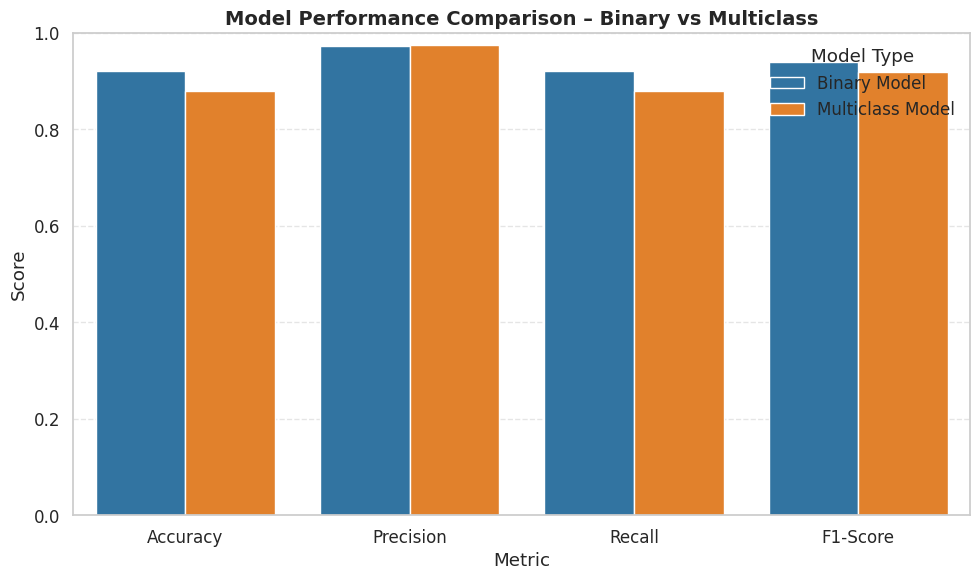

In [124]:
# ============================================================
# 8. Performance Comparison – Binary vs Multiclass Model
# ============================================================

from sklearn.metrics import precision_score, recall_score, f1_score

# ---- Binary model results ----
binary_acc  = accuracy_score(y_test, y_pred)
binary_prec = precision_score(y_test, y_pred, average='weighted')
binary_rec  = recall_score(y_test, y_pred, average='weighted')
binary_f1   = f1_score(y_test, y_pred, average='weighted')

# ---- Multiclass model results ----
# ACHTUNG: hier kommen die *_multi Variablen aus deinem Multiclass-Block rein!
multi_acc  = accuracy_score(y_test_multi, y_pred_multi)
multi_prec = precision_score(y_test_multi, y_pred_multi, average='weighted')
multi_rec  = recall_score(y_test_multi, y_pred_multi, average='weighted')
multi_f1   = f1_score(y_test_multi, y_pred_multi, average='weighted')

# ---- Combine results ----
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Binary Model': [binary_acc, binary_prec, binary_rec, binary_f1],
    'Multiclass Model': [multi_acc, multi_prec, multi_rec, multi_f1]
})

# ---- Plot ----
comparison_df_melt = comparison_df.melt(
    id_vars='Metric', var_name='Model', value_name='Score'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_df_melt,
    x='Metric',
    y='Score',
    hue='Model',
    palette=['#1f77b4', '#ff7f0e']   # kannst durch deine PALETTE_HEX ersetzen
)
plt.title("Model Performance Comparison – Binary vs Multiclass", fontsize=14, fontweight="bold")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Model Type")
plt.tight_layout()
plt.show()
